#### 협업 힡터링
- 어떤 아이템에 대해 비슷한 취향을 가진 사람들은 다른 아이템 또한 비슷한 취향을 가질 것이다.


#### 유사도 지표

#### 피어슨 상관계수 (Pearson Correlation Coefficient)

$$
r_{xy} = 
\frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}
$$

- 평가자료가 연속형인 경우 가장 이해하기 쉬운 유사도(-1 ~ 1 사이값)
- xi, yi는 두 사용자가 공통으로 평가한 아이템 i번쨰 평가값
- 상관관계 범위: **-1 ≤ r ≤ 1**
  - -1 → 완전한 음의 상관관계  
  - 0 → 유사하지 않음  
  - +1 → 완전한 양의 상관관계
- 데이터가 **U자 형태로 분포**되어도 선형 상관성이 없으면 r ≈ 0 → 유사도 0

#### 코사인 유사도
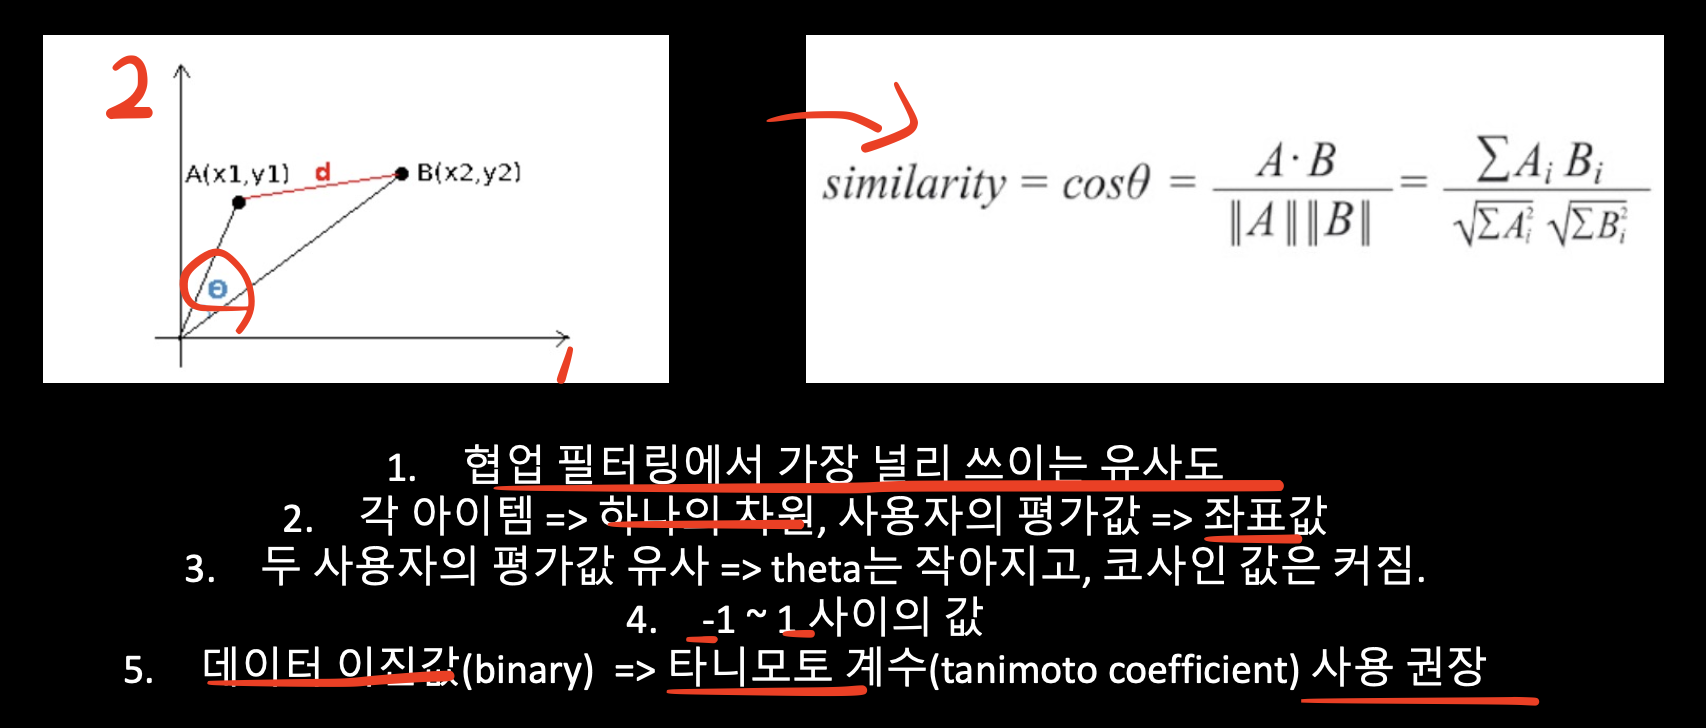
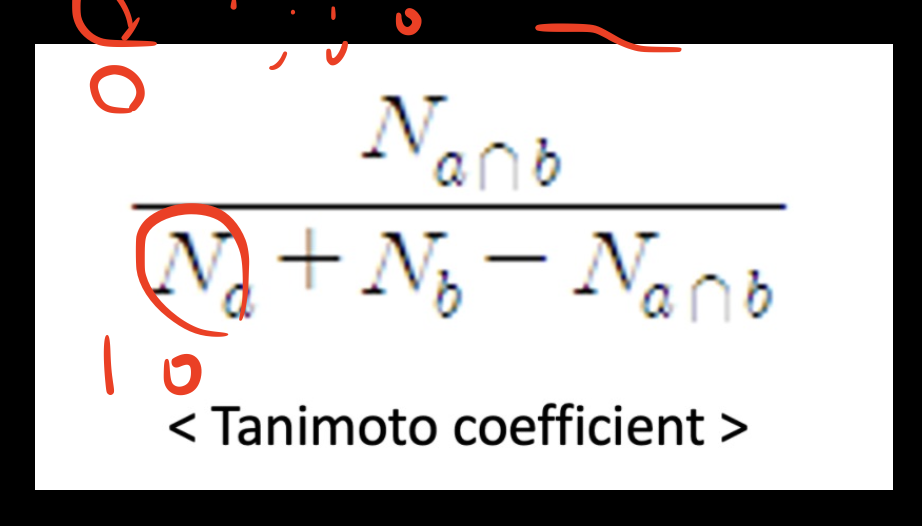
$$
\text{sim}(A, B) = 
\frac{A \cdot B}{\|A\| \|B\|} = 
\frac{\sum_{i=1}^{n} A_i B_i}
{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}
$$

- 협업 필터링에서 **가장 널리 쓰이는 유사도 지표**
- 각 아이템 → 하나의 차원, 사용자의 평가값 → 그 차원의 좌표값
- 두 사용자의 평가값이 유사할수록 θ(벡터 간 각도)는 작아지고 **cos θ 값은 커짐**
- 두 벡터 간의 **방향 유사도(Direction Similarity)** 를 측정 (크기보다는 각도에 집중)
- 값의 범위: **−1 ≤ sim ≤ 1**
  - **1 :** 완전히 같은 방향 (매우 유사)  
  - **0 :** 직교 관계 (관련 없음)  
  - **−1 :** 정반대 방향 (완전히 반대 성향)
- 원시 평점처럼 **음수가 없는 데이터(예: 1 ~ 5점)** 의 경우, 유사도는 사실상 **0 ~ 1** 사이에 분포
- **정규화(Normalization)** 덕분에 사용자마다 평점의 절대 크기 차이가 커도 비교 가능
- 추천 시스템에서는 **희소 행렬(sparse matrix)** 구조에서 계산이 간단해 자주 사용됨


<!-- #### 사용자 간 유사도 계산
$$
\text{sim}(u, v) = 
\frac{\sum_i (r_{u,i} - \bar{r_u})(r_{v,i} - \bar{r_v})}
{\sqrt{\sum_i (r_{u,i} - \bar{r_u})^2} \sqrt{\sum_i (r_{v,i} - \bar{r_v})^2}}
$$

---

#### 예측 평점 계산
$$
\hat{r}_{u,i} = 
\bar{r_u} + 
\frac{\sum_{v \in N(u)} \text{sim}(u, v) \times (r_{v,i} - \bar{r_v})}
{\sum_{v \in N(u)} |\text{sim}(u, v)|}
$$ -->


#### 기본 CF 알고리즘
- 모든 사용자 간 평가의 유사도를 계산
- 추천 대상과 다른 사용자간 유사도 추출
- 추천 대상이 평가하지 않은 아이템에 대한 예상 평가값 계산
- 아이템 중에서 예상 평가값 가장 높은 N개 추천

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 불러오기
# 사용자 u.user파일을 DataFrame으로 읽기
base_src = "./"
u_user_src = os.path.join(base_src, "u.user")
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(u_user_src, sep='|', 
                    names=u_cols, 
                    encoding='latin-1')
users = users.set_index('user_id')
users.head()

# movie 데이터
# u.item 파일을 DataFrame으로 읽기
u_item_src = os.path.join(base_src,'u.item')
i_cols = ['movie_id','title','release date','video release date',
          'IMDB URL','unknown','Action','Adventure','Animation',
          'Children\'s','Comedy','Crime','Documentary','Drama','Fantasy',
          'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
movies = pd.read_csv(u_item_src,
	    sep='|',
            names=i_cols,
            encoding='latin-1')
movies = movies.set_index('movie_id')
movies.head()

# rating 데이터
# u.data 파일을 DataFrame으로 읽기
u_data_src = os.path.join(base_src,'u.data')
r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(u_data_src,
        sep = '\t',
        names = r_cols,
        encoding='latin-1')
ratings.head()


# ----------------------------------------------------------
# RMSE (Root Mean Squared Error, 평균제곱근오차)
# ----------------------------------------------------------
# 예측값(y_pred)과 실제값(y_true)의 차이를 계산하여
# 평균 오차의 크기를 나타내는 함수입니다.
# ➜ 값이 작을수록 모델의 예측이 실제값에 더 가깝습니다.
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# ----------------------------------------------------------
# 모델 성능 평가 함수 (score)
# ----------------------------------------------------------
# 주어진 모델이 테스트 데이터(x_test)에서
# 실제 평점과 얼마나 비슷하게 예측하는지를 RMSE로 평가합니다.
# 
# 1. x_test에서 (user_id, movie_id) 쌍을 추출
# 2. 각 쌍에 대해 model(user, movie)로 예측 평점을 계산
# 3. 실제 평점(y_true)과 비교하여 RMSE 계산
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)


# 데이터 셋 만들기
# 평가 데이터 카피(원본 보존)
x = ratings.copy()          # 전체 평점 데이터를 x에 복사
y = ratings['user_id']      # y는 사용자 ID만 추출 (라벨 역할)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.25,  # train: 75% test: 25
                                                    stratify=y)      # # y(즉, user_id)의 분포를 train/test에 동일하게 유지

ratings_matrix = x_train.pivot(index='user_id',
                              columns='movie_id',
                              values='rating')

ratings_matrix


movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1637,1638,1639,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1652,1653,1654,1655,1656,1658,1659,1660,1661,1663,1664,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,4.0,3.0,3.0,NaN,4.0,NaN,5.0,3.0,2.0,5.0,5.0,5.0,NaN,5.0,3.0,NaN,5.0,4.0,1.0,4.0,4.0,NaN,4.0,3.0,NaN,4.0,1.0,3.0,NaN,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,NaN,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = ratings_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
# pd.DataFrame(user_similarity)
user_similarity = pd.DataFrame(user_similarity,
                               index=ratings_matrix.index,
                               columns=ratings_matrix.index)
user_similarity

/Users/kimdonghyeon/.pyenv/versions/recommend-venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kimdonghyeon/.pyenv/versions/recommend-venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kimdonghyeon/.pyenv/versions/recommend-venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.162727,0.017051,0.040545,0.258314,0.336477,0.354468,0.198733,0.064262,0.323687,0.266952,0.222016,0.321425,0.217445,0.145553,0.310749,0.169193,0.341894,0.065754,0.138279,0.160982,0.280980,0.321372,0.276379,0.237790,0.160089,0.032877,0.224651,0.089601,0.135392,0.114618,0.132957,0.035133,0.030876,0.012956,0.030613,0.154238,0.117253,0.053980,0.084664,...,0.092825,0.122094,0.072325,0.133616,0.170027,0.071329,0.189108,0.263582,0.201872,0.317586,0.049984,0.043641,0.411162,0.109591,0.197735,0.233324,0.036458,0.133104,0.251421,0.105873,0.197735,0.094367,0.076882,0.145908,0.172026,0.224578,0.227619,0.076663,0.219947,0.366318,0.252636,0.059754,0.192345,0.133421,0.096760,0.069377,0.238428,0.090917,0.136139,0.253012
2,0.162727,1.000000,0.093363,0.107836,0.043423,0.195325,0.081032,0.063100,0.152434,0.143146,0.062100,0.085286,0.188609,0.164457,0.387687,0.081137,0.141923,0.175379,0.082204,0.052196,0.117661,0.044491,0.149868,0.170682,0.105813,0.192858,0.143193,0.065981,0.173444,0.214250,0.021208,0.090206,0.088411,0.170262,0.000000,0.148938,0.039445,0.034123,0.164878,0.160283,...,0.141419,0.049555,0.187355,0.183389,0.075064,0.137615,0.236254,0.000000,0.032071,0.138792,0.000000,0.180422,0.075194,0.188212,0.032770,0.255748,0.232093,0.077604,0.089744,0.118330,0.143682,0.028611,0.270627,0.055728,0.124164,0.086970,0.242308,0.350350,0.024746,0.059786,0.089630,0.168270,0.217268,0.314285,0.204132,0.157244,0.100719,0.099868,0.115556,0.070364
3,0.017051,0.093363,1.000000,0.224896,0.029069,0.062109,0.046290,0.074659,0.059156,0.022669,0.056244,0.089852,0.166968,0.042893,0.083282,0.052600,0.006786,0.026989,0.042604,0.000000,0.098641,0.029057,0.020191,0.072337,0.032568,0.095633,0.028402,0.010601,0.093993,0.055971,0.085185,0.090580,0.249892,0.044949,0.167327,0.096266,0.000000,0.053748,0.247107,0.227803,...,0.017820,0.138225,0.014334,0.109594,0.112097,0.048064,0.049706,0.000000,0.000000,0.054083,0.000000,0.280070,0.023011,0.026525,0.000000,0.191574,0.244937,0.045248,0.049564,0.125762,0.053999,0.130879,0.215858,0.042233,0.060655,0.048334,0.024392,0.166510,0.000000,0.048329,0.009505,0.057521,0.114791,0.051315,0.112923,0.019676,0.094715,0.060777,0.124377,0.020369
4,0.040545,0.107836,0.224896,1.000000,0.000000,0.046639,0.067956,0.114860,0.061757,0.054860,0.089351,0.023450,0.101559,0.035823,0.060658,0.062075,0.000000,0.000000,0.129723,0.032425,0.084534,0.007584,0.048745,0.168197,0.027199,0.127792,0.044476,0.103290,0.152960,0.060866,0.076578,0.077369,0.284906,0.211165,0.041772,0.057427,0.035285,0.088375,0.206376,0.268838,...,0.000000,0.112555,0.000000,0.079208,0.074654,0.041815,0.066043,0.025435,0.000000,0.052117,0.000000,0.087715,0.025024,0.016615,0.000000,0.095400,0.068697,0.055984,0.062718,0.083549,0.047564,0.066650,0.249491,0.083770,0.072702,0.018349,0.010186,0.074196,0.000000,0.050453,0.000000,0.000000,0.065366,0.120535,0.052964,0.041081,0.120665,0.139588,0.095009,0.037213
5,0.258314,0.043423,0.029069,0.000000,1.000000,0.173283,0.284193,0.185748,0.072738,0.154289,0.241216,0.079792,0.283541,0.127361,0.062448,0.177472,0.081589,0.210917,0.077608,0.158420,0.098962,0.304883,0.280688,0.088946,0.227812,0.098253,0.087309,0.261660,0.048345,0.135095,0.046552,0.124502,0.000000,0.003509,0.011927,0.000000,0.161619,0.163019,0.000000,0.007217,...,0.015825,0.030215,0.037861,0.101355,0.147868,0.000000,0.140758,0.249647,0.069223,0.237203,0.026237,0.000000,0.256225,0.018844,0.082996,0.132371,0.000000,0.184997,0.256906,0.124066,0.145704,0.048846,0.000000,0.190024,0.030692,0.176493,0.131968,0.073240,0.224314,0.232749,0.285044,0.095614,0.042059,0.028043,0.147569,0.072042,0.122822,0.088017,0.133455,0.19827

In [17]:
# 주어진 영화의(movie_id) 가중평균 rating을 계산하는 함수
def CF_simple(user_id, movie_id):
    if movie_id in ratings_matrix.columns:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = ratings_matrix[movie_id].copy()
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.dropna()
        sim_scores = sim_scores.drop(none_rating_idx)
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating


# 정확도 계산
score(CF_simple)

np.float64(1.0215673824371194)